# Emotion Embedding Test

### Utils

In [1]:
# load packages
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa
import pandas as pd
from models import StyleEncoder

DEVICE = "cuda"
DATA_PATH = "Data/emotion_embedding_test_file.txt"
DATA_HEADER = ["file_path","emotion_id"]
DATA_SEPARETOR = "|"
MODEL_PATH = "Models/Experiment-1"

%matplotlib inline

In [2]:
to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def build_model(model_params={}):
    args = Munch(model_params)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)
    return Munch(style_encoder=style_encoder)

def compute_style(speaker_dicts):
    reference_embeddings = []
    for key, (path, speaker) in speaker_dicts.items():
        wave, sr = librosa.load(path, sr=24000)
        audio, index = librosa.effects.trim(wave, top_db=30)
        if sr != 24000:
            wave = librosa.resample(wave, sr, 24000)
        mel_tensor = preprocess(wave).to(DEVICE)
        with torch.no_grad():
            label = torch.LongTensor([speaker])
            ref = starganv2.style_encoder(mel_tensor.unsqueeze(1), label)
        reference_embeddings.append(ref)
    
    return reference_embeddings

### Load models

In [3]:
# load starganv2

with open(f'{MODEL_PATH}/config.yml') as f:
    starganv2_config = yaml.safe_load(f)
starganv2 = build_model(model_params=starganv2_config["model_params"])
params = torch.load(f"{MODEL_PATH}/ex_1_epoch.pth", map_location=DEVICE)
params = params['model_ema']
_ = [starganv2[key].load_state_dict(params[key]) for key in starganv2 if key == "style_encoder"]
_ = [starganv2[key].eval() for key in starganv2 if key == "style_encoder"]
starganv2.style_encoder = starganv2.style_encoder.to(DEVICE)

#### Convert by style encoder

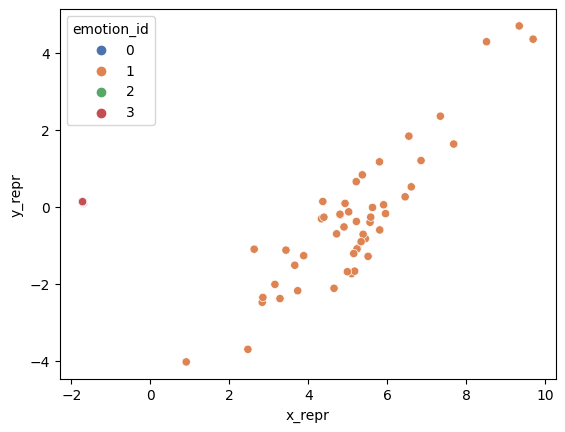

In [4]:
# with reference, using style encoder
dataframe = pd.read_csv(DATA_PATH, sep=DATA_SEPARETOR, names=DATA_HEADER)
emotion_dict ={}
speaker_dicts = {}
for index,speaker_emotion in dataframe.groupby("emotion_id"):
    speaker_dicts={}
    for index, row in speaker_emotion.iterrows():
        speaker_dicts[index] = (row["file_path"], row["emotion_id"])
    emotion_dict[speaker_emotion.iloc[0].emotion_id] = speaker_dicts

emotion_embeddings = {}
embeddings = []
for emotion_idx, data in emotion_dict.items():
    _temp_result=compute_style(data)
    emotion_embeddings[emotion_idx]=_temp_result
    embeddings += _temp_result

embeddings = [embedding.to("cpu").squeeze(0).tolist() for embedding in embeddings]
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
pca = PCA(2)
df = pca.fit_transform(embeddings)
df = pd.DataFrame(df, columns=["x_repr","y_repr"])
dataframe = pd.concat([dataframe,df], axis=1)
sns.scatterplot(data=dataframe, x="x_repr", y="y_repr", hue="emotion_id", palette="deep")
plt.show()
